<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/DRGrading_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import random
import IPython

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize
import cv2

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

random.seed = 2
np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train Data Read

In [ ]:
dataset_images_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']
df_['Retinopathy grade'] = df['Retinopathy grade']

labels = np.array(df_['Retinopathy grade']).reshape(-1, 1)
enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
labels = enc.fit_transform(labels)

a = []
for i in range(len(labels)):
    a.append(labels[i])
    
df_['Retinopathy grade encoded'] = a

df = df_
df.head()

,Image name,Retinopathy grade,Retinopathy grade encoded
0,IDRiD_001,3,"[0, 0, 0, 1, 0]"
1,IDRiD_002,3,"[0, 0, 0, 1, 0]"
2,IDRiD_003,2,"[0, 0, 1, 0, 0]"
3,IDRiD_004,3,"[0, 0, 0, 1, 0]"
4,IDRiD_005,4,"[0, 0, 0, 0, 1]"


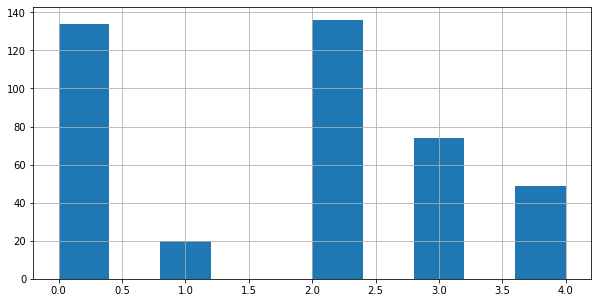

In [ ]:
df['Retinopathy grade'].hist(figsize = (10, 5))

In [ ]:
pt = df.pivot_table(index='Retinopathy grade', aggfunc=len)
print(pt)

                   Image name  Retinopathy grade encoded
Retinopathy grade                                       
0                         134                        134
1                          20                         20
2                         136                        136
3                          74                         74
4                          49                         49


In [ ]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.1) # Here we will perform an 90%/10% split of the dataset, with stratification to keep similar distribution in validation set

42

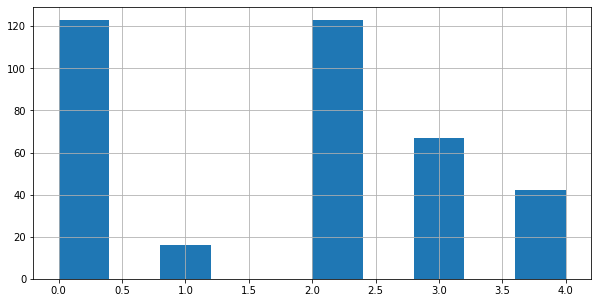

In [ ]:
train_df['Retinopathy grade'].hist(figsize = (10, 5))
len(val_df)


In [ ]:
train_df.pivot_table(index='Retinopathy grade', aggfunc=len)

,Image name,Retinopathy grade encoded
Retinopathy grade,,
0,123,123
1,16,16
2,123,123
3,67,67
4,42,42


New Data Size: 615 Old Size: 371
615


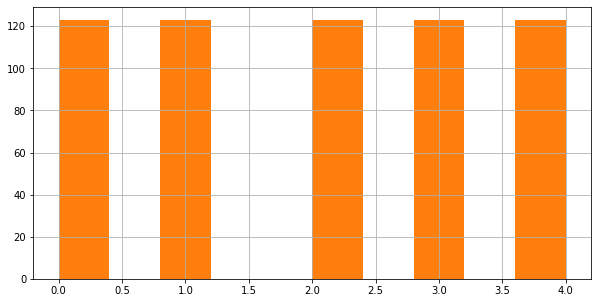

In [ ]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))
print(len(train_df))

#Data Generator

In [ ]:
bs = 8

In [ ]:
def data_gen(df, enc):
    rot=[-4,-3,-2,-1,1,2,3,4]
    images = np.zeros(shape = (bs * 4, 224, 224, 3))
    labels = np.zeros(shape = (bs * 4, 5))
    im_size = 224
    
    counter = 0
    index = 0
    while True:
        if(counter + bs - 1 < len(df)):
            for i in range(bs):
                    # filling images
                    img = cv2.imread(dataset_images_location + '/' + df['Image name'][counter + i] + ".jpg")
                    img = cv2.resize(img, (im_size, im_size))
                    images[index] = img
                    images[index + 1] = (np.flip(img, axis = 0))
                    images[index + 2] = (np.flip(img, axis = 1))
                    images[index + 3] = (np.rot90(np.rot90(img)))

                    #filling labels
                    labels[index] = df['Retinopathy grade encoded'][counter + i]
                    labels[index + 1] = df['Retinopathy grade encoded'][counter + i]
                    labels[index + 2] = df['Retinopathy grade encoded'][counter + i]
                    labels[index + 3] = df['Retinopathy grade encoded'][counter + i]
                    
                    index = index + 4
            
            counter = counter + bs
            images = images.astype('float') / np.max(images)
            index = 0
            yield images, labels
            
        if counter + bs - 1 >= len(df):
            counter = 0
            index = 0


In [ ]:
# image_names = df['Image name'];
# im_size = 224;

# labels = [];
# for label in df['Retinopathy grade']:
#     for i in range(5): # 5 times for data augmentation
#         labels.append(label)

# images_0 = []
# for image_name in image_names:
#     img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
#     img = cv2.resize(img, (im_size, im_size));
#     images_0.append(img);

Data Augmentation

In [ ]:
# rot=[-4,-3,-2,-1,1,2,3,4]

# no_images = 5 * len(images_0)
# images = np.zeros(shape = (no_images, im_size, im_size, 3))

# index = 0

# for image in images_0:
#     images[index] = image
#     images[index + 1] = np.flip(image, axis = 0)
#     images[index + 2] = np.flip(image, axis = 1)
#     images[index + 3] = np.rot90(np.rot90(image))
#     images[index + 4] = scipy.ndimage.rotate(image, random.choice(rot), reshape = False)
#     index = index + 5

# images = np.array(images)
# images = images.astype('float32') / np.max(images)
# labels = np.array(labels, ndmin = 2)
# labels = np.transpose(labels)

# enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
# labels = enc.fit_transform(labels)

# print(images.shape)
# print(labels.shape) 
# labels

# Test Data Read

In [ ]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df)

    Image name  Retinopathy grade
0    IDRiD_001                  4
1    IDRiD_002                  4
2    IDRiD_003                  4
3    IDRiD_004                  4
4    IDRiD_005                  4
..         ...                ...
98   IDRiD_099                  0
99   IDRiD_100                  2
100  IDRiD_101                  1
101  IDRiD_102                  2
102  IDRiD_103                  0

[103 rows x 2 columns]


In [ ]:
test_image_names = [];
test_image_names = test_df['Image name'];
im_size = 224;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = cv2.imread(test_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);


test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 
test_labels

(103, 224, 224, 3)
(103, 5)


array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0,

In [ ]:
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# images, labels = shuffle(images, labels, random_state = 1)

# train_x, val_x, train_y, val_y = train_test_split(images, labels, test_size = 0.1, random_state = 415);

# If train and test are from respective sets
# train_x = images
# train_y = labels
test_x = test_images
test_y = test_labels

# print(train_x.shape)
# print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
# print(val_x.shape)
# print(val_y.shape)

(103, 224, 224, 3)
(103, 5)


# Resnet 50 model

In [ ]:
def identity_block(X, f, filters, d = 0.05):

    #Retrieve filters
    F1, F2, F3 = filters
    
    X_shortcut = X;

    #First Layer
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = layers.Dropout(d)(X)

    #Second Layer
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = layers.Dropout(d)(X)

    #Third Layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)

    #Final Step: Add shortcut to F(X) and pass it through relu activation
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    X = layers.Dropout(d)(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, s = 2, d = 0.05):

    #Retrieve Filters
    F1, F2, F3 = filters

    X_shortcut = X

    # First Layer
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s, s))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)  
    X = layers.Dropout(d)(X)  

    # Second Layer
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)   
    X = layers.Dropout(d)(X) 

    # Third Layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)

    # Shortcut Path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s, s), padding = 'valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    X = layers.Dropout(d)(X)

    return X

In [ ]:
def Resnet50(input_shape = (224, 224, 3), classes = 5, d = 0.05):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2, 2))(X)
    X = layers.Dropout(d)(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    #Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])        

    X = AveragePooling2D((2, 2), name = "avg_pool")(X)
    X = layers.Dropout(d)(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed = 0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name = 'Resnet50')

    return model

# Model Compile and Fit

In [ ]:
random.seed = 2
np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

model = Resnet50(input_shape = (224, 224, 3), classes = 5)
opt = keras.optimizers.Adam(learning_rate = 0.00008, beta_1 = 0.9)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 10)

# model.summary()
# hist = model.fit(train_x, train_y, epochs = 500, batch_size = 32, validation_data = (val_x, val_y), callbacks = [early_stopping], shuffle = True);

train_generator = data_gen(train_df, enc)
# val_generator = data_gen(val_df, enc)

hist = model.fit(train_generator,
                 steps_per_epoch = int(len(train_df)/bs),
                 epochs = 500, 
                #  validation_data = val_generator, 
                #  validation_steps = int(len(val_df) / bs),
                 callbacks = [early_stopping], 
                 shuffle = True)


Epoch 1/500
76/76 [==============================] - 292s 4s/step - loss: 2.5493 - accuracy: 0.2414
Epoch 2/500
76/76 [==============================] - 90s 1s/step - loss: 2.3558 - accuracy: 0.2627
Epoch 3/500
76/76 [==============================] - 90s 1s/step - loss: 2.1705 - accuracy: 0.2821
Epoch 4/500
76/76 [==============================] - 89s 1s/step - loss: 2.0251 - accuracy: 0.2870
Epoch 5/500
76/76 [==============================] - 89s 1s/step - loss: 1.9448 - accuracy: 0.3076
Epoch 6/500
76/76 [==============================] - 89s 1s/step - loss: 1.8897 - accuracy: 0.3236
Epoch 7/500
76/76 [==============================] - 89s 1s/step - loss: 1.7583 - accuracy: 0.3536
Epoch 8/500
76/76 [==============================] - 88s 1s/step - loss: 1.6636 - accuracy: 0.3721
Epoch 9/500
76/76 [==============================] - 88s 1s/step - loss: 1.5895 - accuracy: 0.3902
Epoch 10/500
76/76 [==============================] - 88s 1s/step - loss: 1.5195 - accuracy: 0.4202
Epoch 11

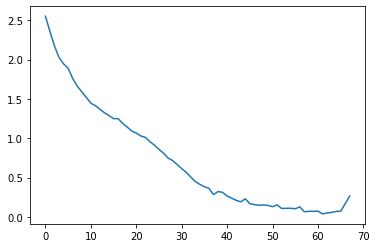

In [ ]:
plt.plot(hist.history['loss'])

Testing

In [ ]:
preds = model.evaluate(test_x, test_y)
print("Loss = " + str(preds[0]))
print("Test accuracy = " + str(preds[1]))

4/4 [==============================] - 0s 112ms/step - loss: 4.1115 - accuracy: 0.4369
Loss = 4.1114912033081055
Test accuracy = 0.43689319491386414


[[18  1  8  1  6]
 [ 2  0  1  1  1]
 [11  1 11  3  6]
 [ 7  0  1  8  3]
 [ 1  0  0  4  8]]


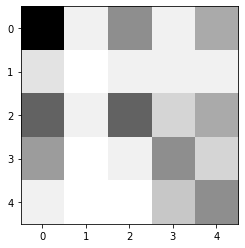

In [ ]:
pred_y = model.predict(test_x)

# By definition a confusion matrix C is such that C[i][j] is equal to the number of observations known to be in group i and predicted to be in group j.
cm = confusion_matrix(np.argmax(test_y, axis = 1), np.argmax(pred_y, axis = 1)) 
print(cm)
plt.imshow(cm, cmap = 'binary')

In [ ]:
# pred_y = model.predict(train_x)

# # By definition a confusion matrix C is such that C[i][j] is equal to the number of observations known to be in group i and predicted to be in group j.
# cm = confusion_matrix(np.argmax(train_y, axis = 1), np.argmax(pred_y, axis = 1)) 
# print(cm)
# plt.imshow(cm, cmap = 'binary')